# **GoogLeNet**
GoogLeNet is a 22-layer deep convolutional neural network that’s a variant of the Inception Network, a Deep Convolutional Neural Network developed by researchers at Google.The GoogLeNet architecture consists of 22 layers (27 layers including pooling layers), and part of these layers are a total of 9 inception modules.

GoogLeNet is a revolutionary network as it significantly decreased the number of parameters in the operation. It had almost 5M parameters which is almost 1/12 times the parameters in AlexNet even while being 22 layers deep.

They introduced the concept of Inception module. The inception module had the concept of applying various filters simulataneously and concatenating the output of all the filters.

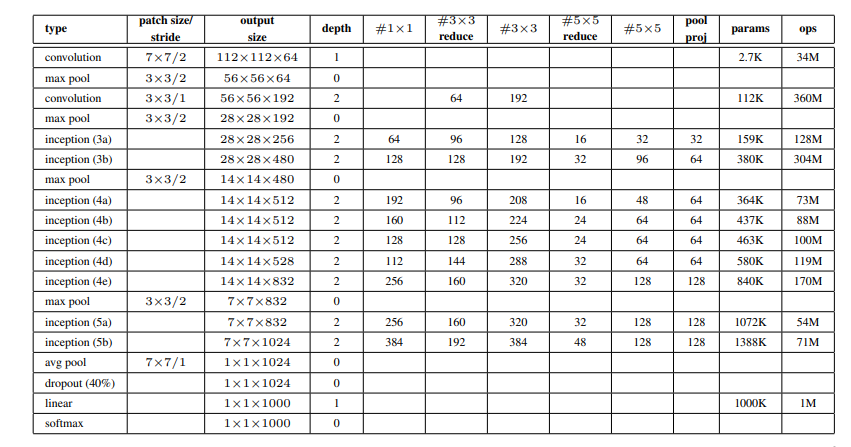

Characteristics and features of GoogLeNet configuration table :

The input layer of the GoogLeNet architecture takes in an image of the dimension 224 x 224.

**Type**: This refers to the name of the current layer of the component within the architecture.

**Patch Size**: Refers to the size of the sweeping window utilised across conv and pooling layers. Sweeping windows have equal height and width.

**Stride**: Defines the amount of shift the filter/sliding window takes over the input image.

**Output Size**: The resulting output dimensions(height, width, number of feature maps) of the current architecture component after the input is passed through the layer.

**Depth**: Refer to the number of levels/layers within an architecture component.

**1x1 3x3 5x5**: Refers to the various convolutions filters used within the inception module.

**3X3 reduce 5x5 reduce**: Refers to the numbers of 1x1 filters used before the convolutions.

**Pool Proj**: This is the number of 1x1 filters used after pooling within an inception module.

**Params**: Refers to the number of weights within the current architecture component.

 **Ops**: Refers to the number of mathematical operations carried out within the component.


**GoogLeNet Architecture Diagram** -

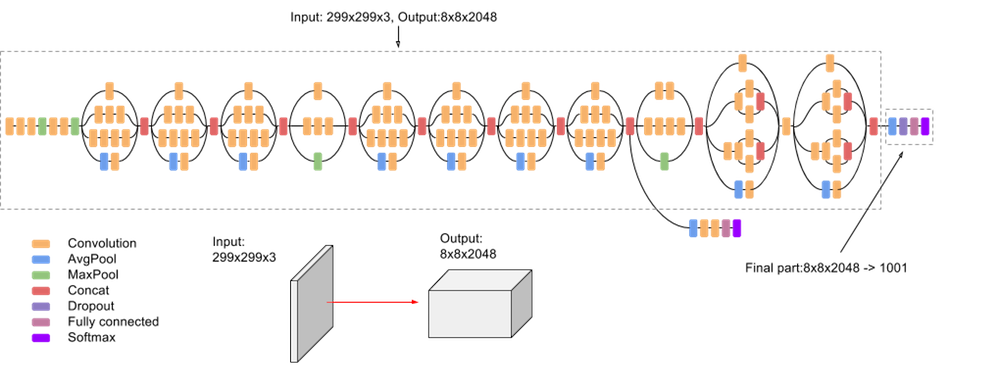


Here is a flow diagram of GoogLeNet -


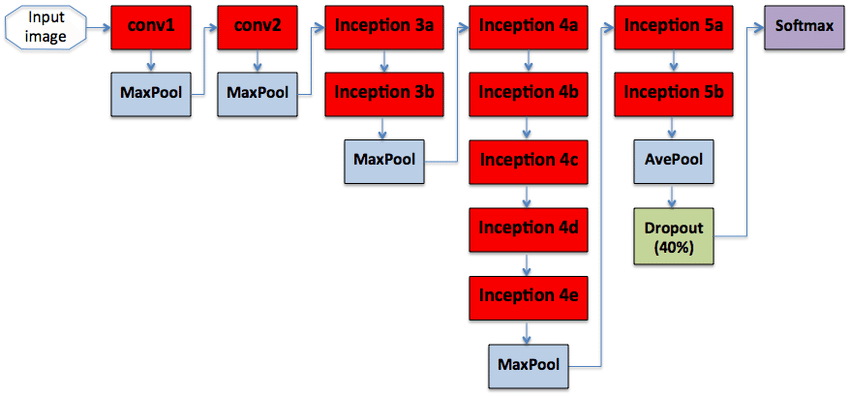

## **Diving deep into the working of GoogLeNet**



**Naive Inception module** : This is the most basic version of the module.
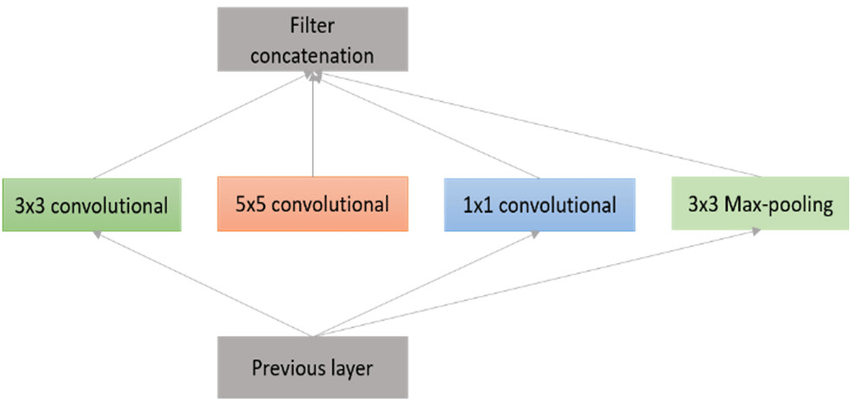


In a traditional conv net, each layer extracts information from the previous layer in order to transform the input data into a more useful representation. However, each layer type extracts a different kind of information. The output of a 5x5 convolutional kernel tells us something different from the output of a 3x3 convolutional kernel, which tells us something different from the output of a max-pooling kernel, and so on and so on. At any given layer, how do we know what transformation provides the most “useful” information?

We let the model choose which filter output to use.An Inception module computes multiple different transformations over the same input map in parallel, concatenating their results into a single output. In other words, for each layer, Inception does a 5x5 convolutional transformation, and a 3x3, and a max-pool. And the next layer of the model gets to decide if (and how) to use each piece of information.

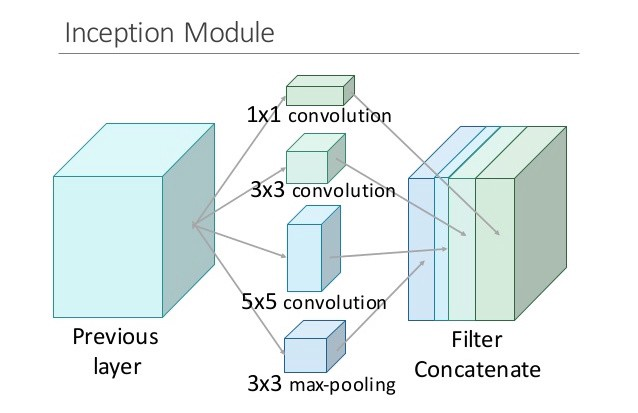



Now, lets move to the coding part of the inception module.

First we will import the required libraries.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data import DataLoader
import torchvision

Now we will define convolutional block just to ease the process of building the model.

In [ ]:
class Conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(Conv_block, self).__init__()
        self.relu = nn.ReLU()
        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
    def forward(self, x):
       return self.relu(self.batchnorm(self.conv(x)))


Now we will move to the main process of building the naive version of inception module.

In [ ]:
class Naive_InceptionBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        out_1x1,
        out_3x3,
        out_5x5,
        out_pool,
    ):
        super(Naive_InceptionBlock, self).__init__()
        self.branch1 = Conv_block(in_channels, out_1x1, kernel_size=1)
        self.branch2 = Conv_block(in_channels, out_3x3, kernel_size=3, padding=1),

        self.branch3 = Conv_block(in_channels, out_5x5, kernel_size=5, padding=2),
  
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
            Conv_block(in_channels, out_pool, kernel_size=1),
        )

    def forward(self, x):
        branches = (self.branch1, self.branch2, self.branch3, self.branch4)
        return torch.cat([branch(x) for branch in branches], 1)

The increased information density of this model architecture comes with one glaring problem: we’ve drastically increased computational costs. Not only are large (e.g. 5x5) convolutional filters inherently expensive to compute, stacking multiple different filters side by side greatly increases the number of feature maps per layer. And this increase becomes a deadly bottleneck in our model.

Let’s say there are M input maps. One additional filter means convolving over M more maps; N additional filters means convolving over N*M more maps. In other words, “any uniform increase in the number of [filters] results in a quadratic increase of computation.” Our naive Inception module just tripled or quadrupled the number of filters. Computationally speaking, this is a Big Bad Thing.

How do we solve this problem of increased computational power ?

This is where the concept of using 1x1 convolutions to perform dimensionality reduction comes in. In order to solve the computational bottleneck, the authors of Inception used 1x1 convolutions to “filter” the depth of the outputs. A 1x1 convolution only looks at one value at a time, but across multiple channels, it can extract spatial information and compress it down to a lower dimension.

Let's understand this with the help of one example :

Let's say we have an image of spatial dimensions 28 $ \times $ 28 and has 192 channels in depth dimension. If we apply 32 filters of size $ 5 \times 5$  directly then the number of operations we have to do is
$ (5 \times 5 \times 192) \times (28 \times 28 \times 32) = 120,422,400 $ i.e. 120 Million operations and the number of parameters is $ 5 \times 5 \times 192 \times 32 = 1,53,600$.






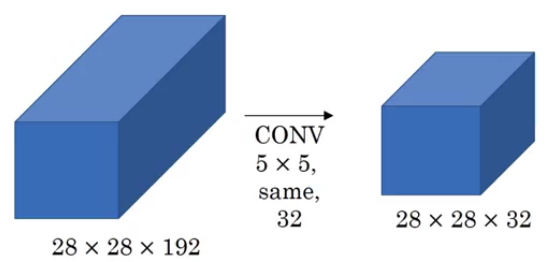

Now, we will apply one intermediate convolutional layer having 16 $1\times1$ kernels and after that we will apply 32 $5 \times 5$ kernels.
Now, lets calculate the number of operations we have to do for $1\times 1 $ layer
$ (28 \times 28 \times 16) \times (1 \times 1 \times 192) =  24,08,448$.

If we calculate for the $5 \times 5$ layer the number of operations is $(28 \times 28 \times 32)\times (5\times 5 \times 16) = 1,00,35,200 $.

So, in total we have to do nearly 12.4 Million operations. The number of parameters in this example is $ (1 \times 1 \times 192 \times 16) +(5 \times 5 \times 16 \times 32) = 15,872. $






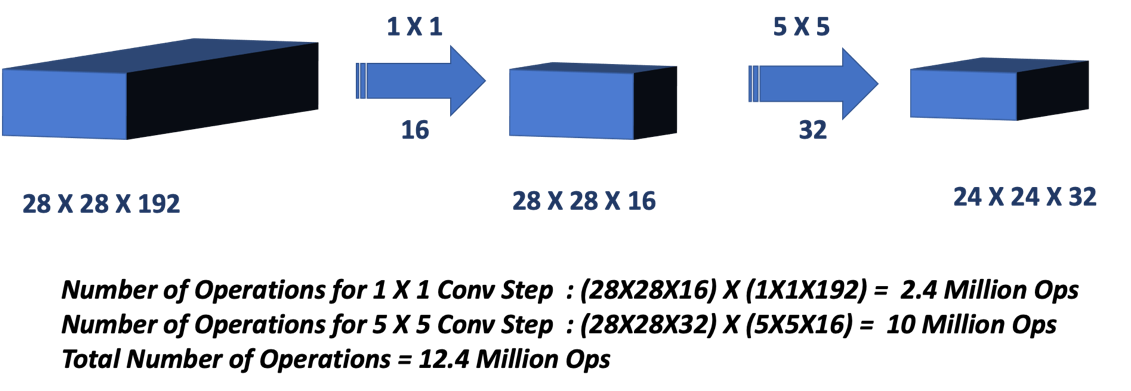

Now, it's time that we apply this newly learned concept to the inception module. We arrive at the second version of inception module now.

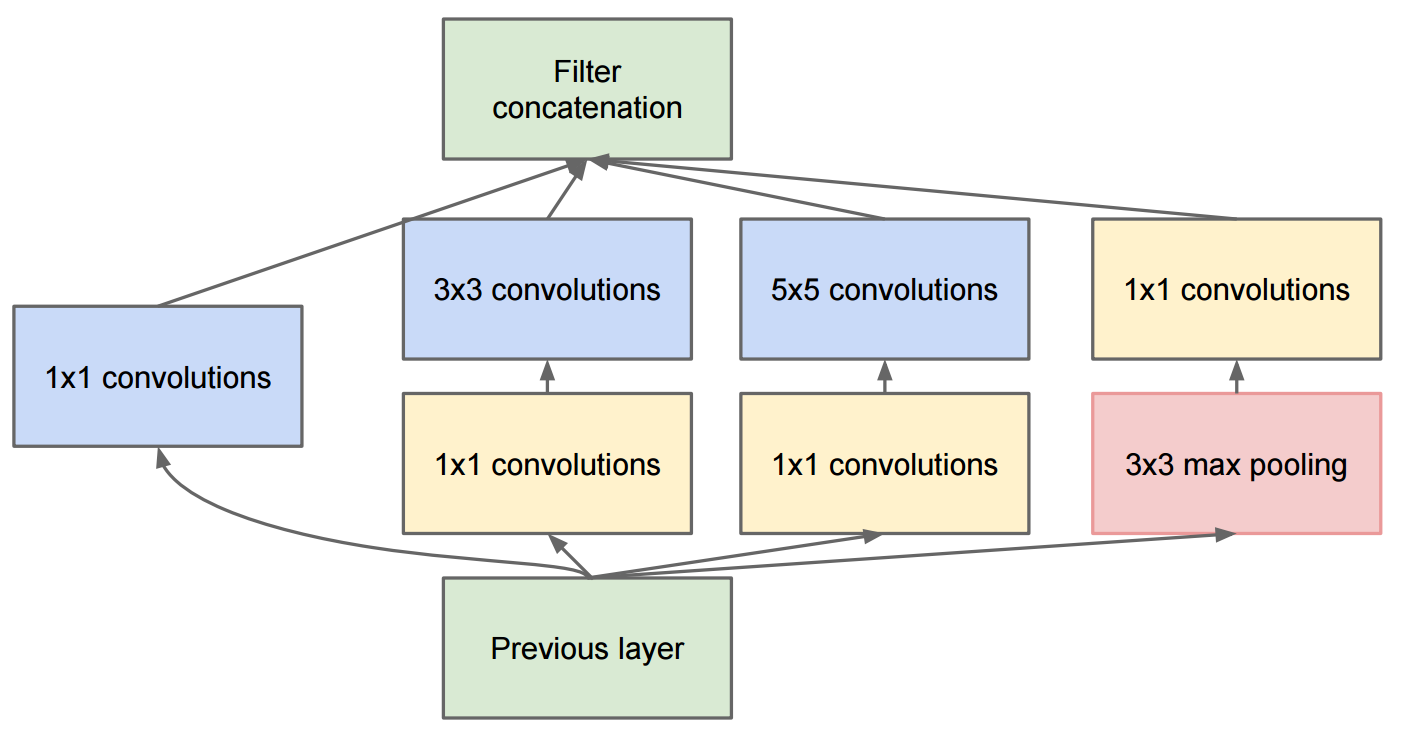

Enough Theory, Let's Code !!


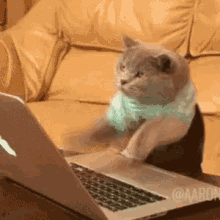

In [ ]:
class Inception_block(nn.Module):
    def __init__(
        self,
        in_channels,
        out_1x1,
        red_3x3,
        out_3x3,
        red_5x5,
        out_5x5,
        out_pool,
    ):
        super(Inception_block, self).__init__()
        self.branch1 = Conv_block(in_channels, out_1x1, kernel_size=1)
        self.branch2 = nn.Sequential(
            Conv_block(in_channels, red_3x3, kernel_size=1, padding=0),
            Conv_block(red_3x3, out_3x3, kernel_size=3, padding=1),
        )
        self.branch3 = nn.Sequential(
            Conv_block(in_channels, red_5x5, kernel_size=1),
            Conv_block(red_5x5, out_5x5, kernel_size=5, padding=2),
        )
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, padding=1, stride=1),
            Conv_block(in_channels, out_pool, kernel_size=1),
        )

    def forward(self, x):
        branches = (self.branch1, self.branch2, self.branch3, self.branch4)
        return torch.cat([branch(x) for branch in branches], 1)

Now let's make the complete GoogLeNet !!! 

In [ ]:
class GoogLeNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(GoogLeNet, self).__init__()
# Write in_channels, etc, all explicit in self.conv1, rest will write to
# make everything as compact as possible, kernel_size=3 instead of (3,3)
        self.conv1 = Conv_block(in_channels=3,out_channels=64,kernel_size=(7, 7),stride=(2, 2),padding=(3, 3))

        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = Conv_block(64, 192, kernel_size=3, stride=1, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

# In this order: in_channels, out_1x1, red_3x3, out_3x3, red_5x5, out_5x5, out_1x1pool
        self.inception3a = Inception_block(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception_block(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=(3, 3), stride=2, padding=1)

        self.inception4a = Inception_block(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception_block(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception_block(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception_block(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception_block(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception5a = Inception_block(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception_block(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)
        self.dropout = nn.Dropout(p=0.4)
        self.fc1 = nn.Linear(1024, num_classes)

        def forward(self, x):
              x = self.conv1(x)
              x = self.maxpool1(x)
              x = self.conv2(x)
              x = self.maxpool2(x)

              x = self.inception3a(x)
              x = self.inception3b(x)
              x = self.maxpool3(x)

              x = self.inception4a(x)

              x = self.inception4b(x)
              x = self.inception4c(x)
              x = self.inception4d(x)

              x = self.inception4e(x)
              x = self.maxpool4(x)
              x = self.inception5a(x)
              x = self.inception5b(x)
              x = self.avgpool(x)
              x = x.reshape(x.shape[0], -1)
              x = self.dropout(x)
              x = self.fc1(x)


              return x


In the original GoogLeNet model, they have calculated error three times.Out of three times, two times we have used it to calculate intermediate error in the model. This error is called Auxiliary classifier error. We calculate this error and add all the three errors to form a final error which we used for training. The reason behind using the three error functions is because of vanishing gradient problem.

## **Improved Versions of GoogLeNet** 


**Inception v2** - Here the main improvement brought about  was instead of using $ 5 \times 5 $ kernel we used 2  $3 \times 3$ kernel to produce the same receptive field but reducing the computational cost and having able to produce non-linear functions more efficiently.

**Inception v3** - 
The authors noted that the auxiliary classifiers didn’t contribute much until near the end of the training process, when accuracies were nearing saturation. They argued that they function as regularizes, especially if they have BatchNorm or Dropout operations.
Possibilities to improve on the Inception v2 without drastically changing the modules were to be investigated.


Inception Net v3 incorporated all of the above upgrades stated for Inception v2, and in addition used the following:
* RMSProp Optimizer.
* Factorized 7x7 convolutions.
* BatchNorm in the Auxillary Classifiers.
* Label Smoothing (A type of regularizing component added to the loss formula that prevents the network from becoming too confident about a class. Prevents over fitting).

**Inception-ResNet v1 and v2** -
Inspired by the performance of the ResNet, a hybrid inception module was proposed. There are two sub-versions of Inception ResNet, namely v1 and v2. Before we checkout the salient features, let us look at the minor differences between these two sub-versions.

Inception-ResNet v1 has a computational cost that is similar to that of Inception v3.

The pooling operation inside the main inception modules were replaced in favor of the residual connections.It was found that Inception-ResNet models were able to achieve higher accuracies at a lower epoch.




## **References**:- 

for GoogLeNet and its working : 
1. [Article](https://towardsdatascience.com/an-intuitive-guide-to-deep-network-architectures-65fdc477db41)
2. [blog ](https://jaketae.github.io/study/pytorch-inception/)

for improved versions of GoogLeNet :
1. [Article](https://towardsdatascience.com/a-simple-guide-to-the-versions-of-the-inception-network-7fc52b863202) 

Fun Fact : 


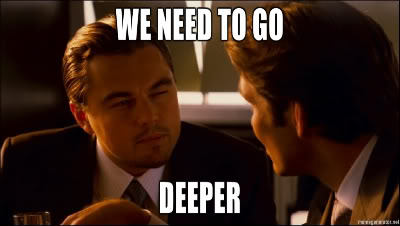

This meme was first referenced in the first inception net research paper.
